In [1]:
"""
@author: Liang Sicong
"""
import sys
import os
import numpy as np
import tensorflow as tf
import time
import numpy as np
import tensorflow as tf
import datetime
from config_gpu import config_gpu
import matplotlib.pyplot as plt
import scipy.io as scio
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Neural network for Wiener-Hopf kernel factorization

In [15]:
class MINN(tf.keras.Model):
    def __init__(self, 
                x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                 Rm, Rn, Rl, depth, activ = "tanh", BN = False, 
                 w_init = "glorot_normal", b_init = "zeros", 
                 lr = 1e-3, opt = "Adam", w_k = 1., w_cr = 1., w_z = 1., w_dense = 0.01,
                 f_mntr = 10, r_seed = 1234):
        
        # initialize the configuration
        super().__init__()
        self.r_seed = r_seed
        self.random_seed(seed = r_seed)
        self.data_type  = tf.float32
        self.Rm     = Rm       # input dimension
        self.Rn     = Rn       # output dimension
        self.Rl     = Rl       # internal dimension width
        self.depth  = depth    # (# of hidden layers) + output layer
        self.activ  = activ    # activation function
        self.BN     = BN       # BatchNorm? 
        self.w_init = w_init   # initial weight
        self.b_init = b_init   # initial bias
        self.lr     = lr       # learning rate
        self.opt    = opt      # name of your optimizer ("SGD", "RMSprop", "Adam", etc.)
        self.w_k    = w_k      # weight for R+ loss
        self.w_cr  = w_cr     # weight for R- loss
        self.w_z    = w_z      # weight for R_junction loss
        self.w_dense = w_dense
        self.f_mntr = f_mntr   # monitoring frequency
        
        # input-output pair
        self.x_plus = x_plus;  self.y_plus = y_plus ;  self.prt_plus = prt_plus;  self.pit_plus = pit_plus 
        self.qrt_plus = qrt_plus;  self.qit_plus = qit_plus;self.rrt_plus = rrt_plus;  self.rit_plus = rit_plus
        self.srt_plus = srt_plus;  self.sit_plus = sit_plus
        self.x_neg = x_neg;  self.y_neg = y_neg ;  self.prt_neg = prt_neg;  self.pit_neg = pit_neg 
        self.qrt_neg = qrt_neg;  self.qit_neg = qit_neg;self.rrt_neg = rrt_neg;  self.rit_neg = rit_neg
        self.srt_neg = srt_neg;  self.sit_neg = sit_neg
        self.x_junc = x_junc;  self.y_junc = y_junc ;  self.prt_junc = prt_junc;  self.pit_junc = pit_junc 
        self.qrt_junc = qrt_junc;  self.qit_junc = qit_junc;self.rrt_junc = rrt_junc;  self.rit_junc = rit_junc
        self.srt_junc = srt_junc;  self.sit_junc = sit_jun
        self.x_circle_plus = x_circle_plus;  self.y_circle_plus = y_circle_plus ;  self.x_circle_neg = x_circle_neg;  self.y_circle_neg = y_circle_neg ;

        
        # call
        self.dnn = self.dnn_init(Rm, Rn, Rl, depth)
        self.dnn.layers[-6].trainable=False
        self.dnn.layers[-5].trainable=False
        self.dnn.layers[-4].trainable=False

        self.params = self.dnn.trainable_variables
        self.optimizer = self.opt_alg(self.lr, self.opt)

        # track loss
        self.ep_log = []
        self.loss_log = []
        
        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
        
    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
    def dnn_init(self, Rm, Rn, Rl, depth):
        # network configuration (N: Rm -> Rn (Rm -> Rl -> ... -> Rl -> Rn))
        network = tf.keras.Sequential()
        network.add(tf.keras.layers.InputLayer(Rm))
#         network.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        
        if self.BN == True:   # False by default
            for l in range(depth - 1):
                network.add(tf.keras.layers.Dense(Rl, activation = self.activ, use_bias = False,
                                                  kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                                                  kernel_regularizer = None, bias_regularizer = None, 
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
                network.add(tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001, 
                                                               center = True, scale = True,
                                                               beta_initializer = "zeros", gamma_initializer = "ones",
                                                               moving_mean_initializer = "zeros",
                                                               moving_variance_initializer = "ones", 
                                                               beta_regularizer = None, gamma_regularizer = None, 
                                                               beta_constraint  = None, gamma_constraint  = None))
            
        else:   # False by default
            for l in range(depth - 1):
#              for l in range(depth - 1):
                if l==3:
                    RR=Rl*2
                else:
                    RR=Rl
                network.add(tf.keras.layers.Dense(RR, activation = self.activ, use_bias = True,
                                                  kernel_initializer = self.w_init, bias_initializer = self.b_init, 
                                                  kernel_regularizer = None, bias_regularizer = None, 
                                                  activity_regularizer = None, kernel_constraint = None, bias_constraint = None))
        network.add(tf.keras.layers.Dense(Rn))
        return network
     
    def opt_alg(self, lr, opt):
        if   opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(learning_rate = lr, momentum = 0.0, nesterov = False)
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False)
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999)
        else:
            raise Exception(">>>>> Exception: optimizer not specified correctly")
            
        return optimizer
    
    def PDEk(self, x, y):
        x = tf.convert_to_tensor(x, dtype = self.data_type)
        y = tf.convert_to_tensor(y, dtype = self.data_type)

        with tf.GradientTape(persistent = True) as tp:
            tp.watch(x)
            tp.watch(y)
            
            uu = self.dnn(tf.concat([x, y], 1))
            pr=uu[:,0:1]
            pi=uu[:,1:2]
            qr=uu[:,2:3]
            qi=uu[:,3:4]
            rr=uu[:,4:5]
            ri=uu[:,5:6]
            sr=uu[:,6:7]
            si=uu[:,7:8]
        del tp
        return pr,pi,qr,qi,rr,ri,sr,si

    ########## kr+i*ki=(a+bi)*(c+di)+(e+fi)*(g+hi)
    def getri(self,a,b,c,d,e,f,g,h):
        kr=a*c-b*d+e*g-f*h
        ki=a*d+b*c+e*h+f*g
        
        return kr,ki
    
    ########## p/g_11(a)
    def getp(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        gamma=tf.sqrt(tf.square(x)-tf.square(k))
        z=-gamma/2*0+1
        xr=tf.compat.v1.real(z)
        xi=tf.compat.v1.imag(z)
        return xr,xi  
    
    ########## q/g_12(a)
    def getq(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        gamma=tf.sqrt(tf.square(x)-tf.square(k))
        j0=tf.complex([0.0],[1.0])
        a=tf.complex([0.0],[0.0])
        h=tf.complex([2.0],[0.0])
#         gamma_plus=tf.sqrt(k+x)
        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg
        z=gamma_neg/gamma_plus*tf.exp(-h*gamma)
        xr=tf.compat.v1.real(z)
        xi=tf.compat.v1.imag(z)
        return xr,xi 
    
    ########## r/g_21(a)
    def getr(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        gamma=tf.sqrt(tf.square(x)-tf.square(k))
        j0=tf.complex([0.0],[1.0])
        a=tf.complex([0.0],[0.0])
        h=tf.complex([2.0],[0.0])
        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg
        z=-gamma_plus/gamma_neg*tf.exp(-h*gamma)
        xr=tf.compat.v1.real(z)
        xi=tf.compat.v1.imag(z)
        return xr,xi   
    
    ########## s/G_22(a)
    def gets(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        gamma=tf.sqrt(tf.square(x)-tf.square(k))
        z=-gamma/2*0+1
        xr=tf.compat.v1.real(z)
        xi=tf.compat.v1.imag(z)
        return xr,xi
    
    ########## beta_plus(a)
    def get_bplus(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        j0=tf.complex([0.0],[1.0])

        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg

        xr=tf.compat.v1.real(gamma_plus)
        xi=tf.compat.v1.imag(gamma_plus)
        return xr[0],xi[0]  
    
    ########## beta_neg(a)
    def get_bneg(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        j0=tf.complex([0.0],[1.0])

        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg

        xr=tf.compat.v1.real(gamma_neg)
        xi=tf.compat.v1.imag(gamma_neg)
        return xr[0],xi[0]  
    
    def get_polar(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([2.5],[0.0050])
        a=w1+2.5
        b=w2+0.0050
        zr=a/(tf.square(a)+tf.square(b))
        zi=-b/(tf.square(a)+tf.square(b))
        return zr,zi
    
    ########## kr+i*ki=(a+bi)*(c+di)
    def get_multiply(self,a,b,c,d):
        kr=a*c-b*d
        ki=a*d+b*c     
        return kr,ki
    
    ########## P(a)
    def get_PP(self,w1,w2):
        x=tf.complex([w1],[w2])
        k=tf.complex([5.0],[0.01])
        j0=tf.complex([0.0],[1.0])
        c1=tf.complex([0.6445],[0.2606])# beta0/(2*pi*1i)/psi0   0.6445 + 0.2606i
        c2=tf.complex([0.1464],[-0.0589])# -psi0/(2*pi*1i)  0.1464 - 0.0589i
        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg
        vecp1=c1/gamma_plus
        vecp2=c2*gamma_plus
        vecp1r=tf.compat.v1.real(vecp1)
        vecp1i=tf.compat.v1.imag(vecp1)
        vecp2r=tf.compat.v1.real(vecp2)
        vecp2i=tf.compat.v1.imag(vecp2)
        
        return vecp1r[0],vecp1i[0],vecp2r[0],vecp2i[0]
    
    ########## 2*2 matrix inversion
    def get_inv(self,pr,pi,qr,qi,rr,ri,sr,si):
        p=tf.complex([pr],[pi])
        q=tf.complex([qr],[qi])
        r=tf.complex([rr],[ri])
        s=tf.complex([sr],[si])
        det=p*s-q*r
        invp=s/det
        invq=-q/det
        invr=-r/det
        invs=p/det
        invpr=tf.compat.v1.real(invp)
        invpi=tf.compat.v1.imag(invp)     
        invqr=tf.compat.v1.real(invq)
        invqi=tf.compat.v1.imag(invq)   
        invrr=tf.compat.v1.real(invr)
        invri=tf.compat.v1.imag(invr)   
        invsr=tf.compat.v1.real(invs)
        invsi=tf.compat.v1.imag(invs)  
        return invpr[0],invpi[0],invqr[0],invqi[0],invrr[0],invri[0],invsr[0],invsi[0]
    
    ########## U*exp(iax) analytic in the upper half-plane
    def get_fexp_plus2(self,w1,w2,f1r,f1i,f2r,f2i,gg):
        x=tf.complex([w1],[w2])
        f1=tf.complex([f1r],[f1i])
        f2=tf.complex([f2r],[f2i])
        j0=tf.complex([0.0],[1.0])
        z0=tf.complex([gg],[0.0])
        expf=tf.exp(j0*x*z0)
        f1x=f1*expf
        f2x=f2*expf
        f1rx=tf.compat.v1.real(f1x)
        f1ix=tf.compat.v1.imag(f1x)
        f2rx=tf.compat.v1.real(f2x)
        f2ix=tf.compat.v1.imag(f2x)
        return f1rx[0],f1ix[0],f2rx[0],f2ix[0]
    
    ########## V*exp(iax) analytic in the lower half-plane
    def get_fexp_neg2(self,w1,w2,f1r,f1i,f2r,f2i,gg):
        x=tf.complex([w1],[w2])
        f1=tf.complex([f1r],[f1i])
        f2=tf.complex([f2r],[f2i])
        j0=tf.complex([0.0],[1.0])
        z0=tf.complex([gg],[0.0])
        expf=tf.exp(j0*x*z0)
        f1x=f1*expf
        f2x=f2*expf
        f1rx=tf.compat.v1.real(f1x)
        f1ix=tf.compat.v1.imag(f1x)
        f2rx=tf.compat.v1.real(f2x)
        f2ix=tf.compat.v1.imag(f2x)
        return f1rx[0],f1ix[0],f2rx[0],f2ix[0]     
    
    ########## U1,U2 analytic in the upper half-plane
    def get_fplus(self,w1,w2,pr,pi,qr,qi,rr,ri,sr,si,\
                       inv_kpr,inv_kpi,inv_kqr,inv_kqi,inv_krr,inv_kri,inv_ksr,inv_ksi,\
                       kvecp1r,kvecp1i,kvecp2r,kvecp2i,\
                       vecp1r,vecp1i,vecp2r,vecp2i):
        x=tf.complex([w1],[w2])
        p=tf.complex([pr],[pi])
        q=tf.complex([qr],[qi])
        r=tf.complex([rr],[ri])
        s=tf.complex([sr],[si])
        pk=tf.complex([inv_kpr],[inv_kpi])
        qk=tf.complex([inv_kqr],[inv_kqi])
        rk=tf.complex([inv_krr],[inv_kri])
        sk=tf.complex([inv_ksr],[inv_ksi])
        PPK1=tf.complex([kvecp1r],[kvecp1i])
        PPK2=tf.complex([kvecp2r],[kvecp2i])
        PPA1=tf.complex([vecp1r],[vecp1i])
        PPA2=tf.complex([vecp2r],[vecp2i])     
        k0=tf.complex([2.5],[0.0050]) 
        k=tf.complex([5.0],[0.010]) 
        F1=(p*pk+q*rk)*PPK1+(p*qk+q*sk)*PPK2-PPA1
        F2=(r*pk+s*rk)*PPK1+(r*qk+s*sk)*PPK2-PPA2
        j0=tf.complex([0.0],[1.0])
        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        gamma_neg=tf.sqrt(k-x)
        b_plus=gammaj/gamma_neg
        F1A=F1/(x+k0)*b_plus
        F2A=F2/(x+k0)/b_plus
        f1r=tf.compat.v1.real(F1A)
        f1i=tf.compat.v1.imag(F1A)
        f2r=tf.compat.v1.real(F2A)
        f2i=tf.compat.v1.imag(F2A)
        return f1r[0],f1i[0],f2r[0],f2i[0]
    
    ########## V1,V2 analytic in the lower half-plane
    def get_fneg(self,w1,w2,pr,pi,qr,qi,rr,ri,sr,si,\
                       inv_kpr,inv_kpi,inv_kqr,inv_kqi,inv_krr,inv_kri,inv_ksr,inv_ksi,\
                       kvecp1r,kvecp1i,kvecp2r,kvecp2i):
        x=tf.complex([w1],[w2])
        p=tf.complex([pr],[pi])
        q=tf.complex([qr],[qi])
        r=tf.complex([rr],[ri])
        s=tf.complex([sr],[si])
        pk=tf.complex([inv_kpr],[inv_kpi])
        qk=tf.complex([inv_kqr],[inv_kqi])
        rk=tf.complex([inv_krr],[inv_kri])
        sk=tf.complex([inv_ksr],[inv_ksi])
        PPK1=tf.complex([kvecp1r],[kvecp1i])
        PPK2=tf.complex([kvecp2r],[kvecp2i])    
        k0=tf.complex([2.5],[0.0050]) 
        k=tf.complex([5.0],[0.010]) 
        j0=tf.complex([0.0],[1.0])
        gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
        b_neg=tf.sqrt(k-x)
        gamma_neg=tf.sqrt(k-x)
        gamma_plus=gammaj/gamma_neg
        F1=(p*pk+q*rk)*PPK1+(p*qk+q*sk)*PPK2
        F2=(r*pk+s*rk)*PPK1+(r*qk+s*sk)*PPK2
        F1A=F1/(x+k0)/b_neg
        F2A=F2/(x+k0)*b_neg
        f1r=tf.compat.v1.real(F1A)
        f1i=tf.compat.v1.imag(F1A)
        f2r=tf.compat.v1.real(F2A)
        f2i=tf.compat.v1.imag(F2A)
        return f1r[0],f1i[0],f2r[0],f2i[0]

    def PDE(self, x, y):
        x = tf.convert_to_tensor(x, dtype = self.data_type)
        y = tf.convert_to_tensor(y, dtype = self.data_type)

        with tf.GradientTape(persistent = True) as tp:
#         with tf.GradientTape(persistent = False) as tp:
            tp.watch(x)
            tp.watch(y)
        
            ########## G_{+}^{-1}
            uu = self.dnn(tf.concat([x, y], 1)) # input: complex \alpha, output: G_{+}^{-1}(\alpha)
            pr=uu[:,0:1]  # real part of g_11(p)
            pi=uu[:,1:2]  # imag part of g_11(p)
            qr=uu[:,2:3]  # real part of g_12(q)
            qi=uu[:,3:4]  # imag part of g_12(q)
            rr=uu[:,4:5]  # real part of g_21(r)
            ri=uu[:,5:6]  # imag part of g_21(r)
            sr=uu[:,6:7]  # real part of g_22(s)
            si=uu[:,7:8]  # imag part of g_22(s)
            br,bi=self.get_bplus(x,y) # beta_plus
            nbr,nbi=self.get_bneg(x,y)  # beta_neg
            qrx=(qr*br+qi*bi)/(br*br+bi*bi)  # q=\hat{q}/beta_plus
            qix=(-qr*bi+qi*br)/(br*br+bi*bi) # q=\hat{q}/beta_plus
            qr=qrx;qi=qix
            rrx=rr*br-ri*bi                  # r=\hat{q}*beta_plus
            rix=rr*bi+br*ri                  # r=\hat{q}*beta_plus
            rr=rrx;ri=rix

            ########## G
            prt,pit=self.getp(x,y)   
            qrt,qit=self.getq(x,y)
            rrt,rit=self.getr(x,y)
            srt,sit=self.gets(x,y)
            prt=prt[0];pit=pit[0];qrt=qrt[0];qit=qit[0];
            rrt=rrt[0];rit=rit[0];srt=srt[0];sit=sit[0]

            ########## G_{-}= G_{+}^{-1}G
            pr2,pi2= self.getri(pr,pi,prt,pit,qr,qi,rrt,rit)
            qr2,qi2= self.getri(pr,pi,qrt,qit,qr,qi,srt,sit)
            rr2,ri2= self.getri(rr,ri,prt,pit,sr,si,rrt,rit)
            sr2,si2= self.getri(rr,ri,qrt,qit,sr,si,srt,sit)
            
            ########## Auto differentiation of G_{+}^{-1}
            pr_x = tp.gradient(pr, x);pr_y = tp.gradient(pr, y)
            pi_x = tp.gradient(pi, x);pi_y = tp.gradient(pi, y)
            qr_x = tp.gradient(qr, x);qr_y = tp.gradient(qr, y)
            qi_x = tp.gradient(qi, x);qi_y = tp.gradient(qi, y)
            rr_x = tp.gradient(rr, x);rr_y = tp.gradient(rr, y)
            ri_x = tp.gradient(ri, x);ri_y = tp.gradient(ri, y)
            sr_x = tp.gradient(sr, x);sr_y = tp.gradient(sr, y)
            si_x = tp.gradient(si, x);si_y = tp.gradient(si, y)

            ########## Just neglect it
            pr2_x = pr_x;pr2_y = pr_y
            pi2_x = pi_x;pi2_y = pi_y
            qr2_x = qr_x;qr2_y = qr_y
            qi2_x = qi_x;qi2_y = qi_y
            rr2_x = rr_x;rr2_y = rr_y
            ri2_x = ri_x;ri2_y = ri_y    
            sr2_x = sr_x;sr2_y = sr_y
            si2_x = si_x;si2_y = si_y
     
        del tp
        ########## Caucy-Riemann equations
        gv1 = pr_x-pi_y;  gv2 = pr_y+pi_x # du/dx-dv/dy     positive Caucy-Riemann
        gv3 = qr_x-qi_y;  gv4 = qr_y+qi_x # du/dx-dv/dy     positive Caucy-Riemann
        gv5 = rr_x-ri_y;  gv6 = rr_y+ri_x # du/dx-dv/dy     positive Caucy-Riemann
        gv7 = sr_x-si_y;  gv8 = sr_y+si_x # du/dx-dv/dy     positive Caucy-Riemann
        gh1 = pr2_x-pi2_y;  gh2 = pr2_y+pi2_x # du/dx-dv/dy     positive Caucy-Riemann
        gh3 = qr2_x-qi2_y;  gh4 = qr2_y+qi2_x # du/dx-dv/dy     positive Caucy-Riemann
        gh5 = rr2_x-ri2_y;  gh6 = rr2_y+ri2_x # du/dx-dv/dy     positive Caucy-Riemann
        gh7 = sr2_x-si2_y;  gh8 = sr2_y+si2_x # du/dx-dv/dy     positive Caucy-Riemann
        return pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8
    
    ########## Caucy-Riemann equations
    def get_jifen(self,a,b,c,d):
        xr=a*c-b*d
        xi=b*c+a*d
        return xr,xi
    
    ########## L_CI and L_BC in the upper half-plane
    ########## l_CI: Caucy integral loss
    ########## l_BC: Boundary condition loss
    def loss_circle_plus(self, x, y, prt,pit,qrt,qit,rrt,rit,srt,sit):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x, y)  ### G(alpha)
        xx_kminus=np.ones([1,1])*(-2.5)
        yy_kminus=np.ones([1,1])*(-0.0050)
        kpr,kpi,kqr,kqi,krr,kri,ksr,ksi,\
               kpr2,kpi2,kqr2,kqi2,krr2,kri2,ksr2,ksi2,\
               kgv1,kgv2,kgv3,kgv4,kgv5,kgv6,kgv7,kgv8,\
               kgh1,kgh2,kgh3,kgh4,kgh5,kgh6,kgh7,kgh8 = self.PDE(xx_kminus, yy_kminus) ###G+^-1(-k0)
        kvecp1r,kvecp1i,kvecp2r,kvecp2i=self.get_PP(-2.5, -0.0050)   ### p(-k0)
        inv_pr,inv_pi,inv_qr,inv_qi,inv_rr,inv_ri,inv_sr,inv_si=\
                                    self.get_inv(pr,pi,qr,qi,rr,ri,sr,si) ### G+(alpha)
        ######################################################################
        ########## l_CI: Caucy integral loss
        N2=2000
        NK=0
        dx=x[NK+1:NK+N2,:]-x[NK:NK+N2-1,:]
        dy=y[NK+1:NK+N2,:]-y[NK:NK+N2-1,:]
        k1,k2=self.get_jifen(pr[NK+1:NK+N2,:],pi[NK+1:NK+N2,:],dx,dy)
        k3,k4=self.get_jifen(qr[NK+1:NK+N2,:],qi[NK+1:NK+N2,:],dx,dy)    
        k5,k6=self.get_jifen(rr[NK+1:NK+N2,:],ri[NK+1:NK+N2,:],dx,dy)
        k7,k8=self.get_jifen(sr[NK+1:NK+N2,:],si[NK+1:NK+N2,:],dx,dy)  
        loss_prd2 =tf.square(tf.reduce_sum(k1))+tf.square(tf.reduce_sum(k2))\
        +tf.square(tf.reduce_sum(k3))+tf.square(tf.reduce_sum(k4))\
        +tf.square(tf.reduce_sum(k5))+tf.square(tf.reduce_sum(k6))\
        +tf.square(tf.reduce_sum(k7))+tf.square(tf.reduce_sum(k8))      
        
        ######################################################################
        ########## l_BC: Boundary condition loss
        N2=10000
        NK=2000
        dx2=x[NK+1:NK+N2,:]-x[NK:NK+N2-1,:]
        dy2=y[NK+1:NK+N2,:]-y[NK:NK+N2-1,:]
        x2=x[NK:NK+N2-1,:]
        y2=y[NK:NK+N2-1,:]
        vecp1r,vecp1i,vecp2r,vecp2i=self.get_PP(x2,y2)   ### p(alpha)
        loss_prd3=0
        f1r,f1i,f2r,f2i=self.get_fplus(x2,y2,inv_pr[NK:NK+N2-1,:],inv_pi[NK:NK+N2-1,:],inv_qr[NK:NK+N2-1,:],inv_qi[NK:NK+N2-1,:],\
                                             inv_rr[NK:NK+N2-1,:],inv_ri[NK:NK+N2-1,:],inv_sr[NK:NK+N2-1,:],inv_si[NK:NK+N2-1,:],\
                                             kpr,kpi,kqr,kqi,krr,kri,ksr,ksi,\
                                             kvecp1r,kvecp1i,kvecp2r,kvecp2i,\
                                             vecp1r,vecp1i,vecp2r,vecp2i)
        for ii in range(0,600,2):
            if ii<400:
                zz=ii*0.1
            else:
                zz=40+(ii-400)*1.0
            f1rz,f1iz,f2rz,f2iz=self.get_fexp_plus2(x2,y2,f1r,f1i,f2r,f2i,zz)
            print('f1r_plus.shape:'+str(f1rz.shape))
    #         print('pr2_alpha.shape:'+str(pr2_alpha.shape))
            kk1,kk2=self.get_jifen(f1rz,f1iz,dx2,dy2)
            kk3,kk4=self.get_jifen(f2rz,f2iz,dx2,dy2)
            print('kk1_plus.shape:'+str(kk1.shape))
            loss_prd3 =loss_prd3+tf.square(tf.reduce_sum(kk1))+tf.square(tf.reduce_sum(kk2))\
            +tf.square(tf.reduce_sum(kk3))+tf.square(tf.reduce_sum(kk4))  

        loss_prd = loss_prd2*10000+loss_prd3*100
        return loss_prd

    
    ########## L_CI and L_BC in the upper half-plane
    ########## l_CI: Caucy integral loss
    ########## l_BC: Boundary condition loss
    def loss_circle_neg(self, x, y, prt,pit,qrt,qit,rrt,rit,srt,sit):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x, y)  ### G(alpha)
        xx_kminus=np.ones([1,1])*(-2.5)
        yy_kminus=np.ones([1,1])*(-0.0050)
        kpr,kpi,kqr,kqi,krr,kri,ksr,ksi,\
               kpr2,kpi2,kqr2,kqi2,krr2,kri2,ksr2,ksi2,\
               kgv1,kgv2,kgv3,kgv4,kgv5,kgv6,kgv7,kgv8,\
               kgh1,kgh2,kgh3,kgh4,kgh5,kgh6,kgh7,kgh8 = self.PDE(xx_kminus, yy_kminus)  ### G+^-1(-k0)
        kvecp1r,kvecp1i,kvecp2r,kvecp2i=self.get_PP(-2.5, -0.0050)   ### p(-k0)
        ######################################################################
        ########## l_CI: Caucy integral loss
        N2=2000
        NK=0
        dx=x[NK+1:NK+N2,:]-x[NK:NK+N2-1,:]
        dy=y[NK+1:NK+N2,:]-y[NK:NK+N2-1,:]
        k1,k2=self.get_jifen(pr2[NK+1:NK+N2,:],pi2[NK+1:NK+N2,:],dx,dy)
        k3,k4=self.get_jifen(qr2[NK+1:NK+N2,:],qi2[NK+1:NK+N2,:],dx,dy)    
        k5,k6=self.get_jifen(rr2[NK+1:NK+N2,:],ri2[NK+1:NK+N2,:],dx,dy)
        k7,k8=self.get_jifen(sr2[NK+1:NK+N2,:],si2[NK+1:NK+N2,:],dx,dy)   
        loss_prd2 =tf.square(tf.reduce_sum(k1))+tf.square(tf.reduce_sum(k2))\
        +tf.square(tf.reduce_sum(k3))+tf.square(tf.reduce_sum(k4))\
        +tf.square(tf.reduce_sum(k5))+tf.square(tf.reduce_sum(k6))\
        +tf.square(tf.reduce_sum(k7))+tf.square(tf.reduce_sum(k8))
        N2=10000
        NK=2000
        loss_prd3=0
        dx2=x[NK+1:NK+N2,:]-x[NK:NK+N2-1,:]
        dy2=y[NK+1:NK+N2,:]-y[NK:NK+N2-1,:]
        x2=x[NK:NK+N2-1,:]
        y2=y[NK:NK+N2-1,:]
        inv_pr2,inv_pi2,inv_qr2,inv_qi2,inv_rr2,inv_ri2,inv_sr2,inv_si2=\
         self.get_inv(pr2[NK:NK+N2-1,:],pi2[NK:NK+N2-1,:],qr2[NK:NK+N2-1,:],qi2[NK:NK+N2-1,:],rr2[NK:NK+N2-1,:],ri2[NK:NK+N2-1,:],sr2[NK:NK+N2-1,:],si2[NK:NK+N2-1,:]) ### G-^-1(alpha)
        f1r,f1i,f2r,f2i=self.get_fneg(x2,y2,inv_pr2,inv_pi2,inv_qr2,inv_qi2,inv_rr2,inv_ri2,inv_sr2,inv_si2,\
                                         kpr,kpi,kqr,kqi,krr,kri,ksr,ksi,\
                                         kvecp1r,kvecp1i,kvecp2r,kvecp2i)
        ######################################################################
        ########## l_BC: Boundary condition loss
        for ii in range(0,600,2):
            if ii<400:
                zz=-ii*0.1
            else:
                zz=-40-(ii-400)*1.0                
            f1rz,f1iz,f2rz,f2iz=self.get_fexp_neg2(x2,y2,f1r,f1i,f2r,f2i,zz)
            kk1,kk2=self.get_jifen(f1rz,f1iz,dx2,dy2)
            kk3,kk4=self.get_jifen(f2rz,f2iz,dx2,dy2) 
            loss_prd3 =loss_prd3+tf.square(tf.reduce_sum(kk1))+tf.square(tf.reduce_sum(kk2))\
            +tf.square(tf.reduce_sum(kk3))+tf.square(tf.reduce_sum(kk4))  
        loss_prd = loss_prd2*10000+loss_prd3*100
        return loss_prd

    ########## L_CR in the whole complex \alpha plane
    def loss_pde_plus(self, x, y, prt,pit,qrt,qit,rrt,rit,srt,sit):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x, y)

        loss_prd3 =tf.reduce_mean(tf.square(gv1))+tf.reduce_mean(tf.square(gv2))\
        +tf.reduce_mean(tf.square(gv3))+tf.reduce_mean(tf.square(gv4))\
        +tf.reduce_mean(tf.square(gv5))+tf.reduce_mean(tf.square(gv6))\
        +tf.reduce_mean(tf.square(gv7))+tf.reduce_mean(tf.square(gv8))
        loss_prd = loss_prd3
        return loss_prd
    
    ########## Just neglect it
    def loss_pde_neg(self, x, y, prt,pit,qrt,qit,rrt,rit,srt,sit):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x, y)

        loss_prd3 =tf.reduce_mean(tf.square(gh1))+tf.reduce_mean(tf.square(gh2))\
        +tf.reduce_mean(tf.square(gh3))+tf.reduce_mean(tf.square(gh4))

        loss_prd = loss_prd3
        return loss_prd
    
    ########## L_V in the splice region, the lower bound is 0.2
    def loss_pde_junc(self, x, y, prt,pit,qrt,qit,rrt,rit,srt,sit):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x, y)
        
        loss_prd3=tf.nn.relu(-tf.reduce_mean(tf.sqrt(tf.square(pr)+tf.square(pi)))+0.2)\
        +tf.nn.relu(-tf.reduce_mean(tf.sqrt(tf.square(qr)+tf.square(qi)))+0.2)\
        +tf.nn.relu(-tf.reduce_mean(tf.sqrt(tf.square(rr)+tf.square(ri)))+0.2)\
        +tf.nn.relu(-tf.reduce_mean(tf.sqrt(tf.square(sr)+tf.square(si)))+0.2)
        loss_prd4 =tf.reduce_mean(tf.square(gv1))+tf.reduce_mean(tf.square(gv2))\
        +tf.reduce_mean(tf.square(gv3))+tf.reduce_mean(tf.square(gv4))\
        +tf.reduce_mean(tf.square(gv5))+tf.reduce_mean(tf.square(gv6))\
        +tf.reduce_mean(tf.square(gv7))+tf.reduce_mean(tf.square(gv8))
        loss_prd = tf.square(loss_prd3/0.2)*100+loss_prd4
        return loss_prd    
    
    @tf.function
    def loss_glb(self, 
                 x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,ww1,ww2):
        loss_plus   =  self.loss_pde_plus(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus)
#         loss_neg   =  self.loss_pde_neg(x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg)
        loss_junc   = self.loss_pde_junc(x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc)
        loss_neg=loss_junc
        loss_circle_plus   =  self.loss_circle_plus(x_circle_plus, y_circle_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus)
        loss_circle_neg   =  self.loss_circle_neg(x_circle_neg, y_circle_neg, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus)
        loss= (loss_plus*self.w_k +loss_junc*self.w_k)+(loss_circle_plus*self.w_cr+loss_circle_neg*self.w_cr)
        return loss,loss_plus,loss_neg,loss_junc,loss_circle_plus,loss_circle_neg

    def loss_grad(self, 
                 x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,ww1,ww2): 
        with tf.GradientTape(persistent = True) as tp:
            loss,loss_plus,loss_neg,loss_junc,loss_circle_plus,loss_circle_neg = self.loss_glb(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,
                                                              x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,ww1,ww2)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss,loss_plus,loss_neg,loss_junc,loss_circle_plus,loss_circle_neg,grad
    
    @tf.function
    def grad_desc(self, 
                 x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,ww1,ww2):
        loss,loss_plus,loss_neg,loss_junc, loss_circle_plus,loss_circle_neg,grad = self.loss_grad(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,
                                                                 x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,ww1,ww2)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss,loss_plus,loss_neg,loss_junc,loss_circle_plus,loss_circle_neg
        
    def train(self, epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5): 
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)
        
        t0 = time.time()
        x_plus = self.x_plus.numpy(); y_plus = self.y_plus.numpy()
        prt_plus = self.prt_plus.numpy();pit_plus = self.pit_plus.numpy()
        qrt_plus = self.qrt_plus.numpy();qit_plus = self.qit_plus.numpy()
        rrt_plus = self.rrt_plus.numpy();rit_plus = self.rit_plus.numpy()
        srt_plus = self.srt_plus.numpy();sit_plus = self.sit_plus.numpy()
        x_neg = self.x_neg.numpy(); y_neg = self.y_neg.numpy()
        prt_neg = self.prt_neg.numpy();pit_neg = self.pit_neg.numpy()
        qrt_neg = self.qrt_neg.numpy();qit_neg = self.qit_neg.numpy()
        rrt_neg = self.rrt_neg.numpy();rit_neg = self.rit_neg.numpy()
        srt_neg = self.srt_neg.numpy();sit_neg = self.sit_neg.numpy()
        x_junc = self.x_junc.numpy(); y_junc = self.y_junc.numpy()
        prt_junc = self.prt_junc.numpy();pit_junc = self.pit_junc.numpy()
        qrt_junc = self.qrt_junc.numpy();qit_junc = self.qit_junc.numpy()
        rrt_junc = self.rrt_junc.numpy();rit_junc = self.rit_junc.numpy()
        srt_junc = self.srt_junc.numpy();sit_junc = self.sit_junc.numpy()
        ww1=1
        ww2=1
        for ep in range(epoch):
            ep_loss = 0
            ep_loss_plus = 0
            ep_loss_neg = 0
            ep_loss_junc = 0
                
            if batch == 0:   # full-batch training
                ep_loss = self.grad_desc(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc)
            
            else:   # mini-batch training
                n_plus = self.x_plus.shape[0]; idx_plus = np.random.permutation(n_plus)
                n_neg = self.x_neg.shape[0]; idx_neg = np.random.permutation(n_neg)
                n_junc = self.x_junc.shape[0]; idx_junc = np.random.permutation(n_junc)

                n_data = self.x_plus.shape[0] + self.x_neg.shape[0] + self.x_junc.shape[0]
                shf_idx = np.random.permutation(n_data)
                
                for idx in range(0, n_junc, batch):
                    # batch for R+
                    
                    x_plus_btch = tf.convert_to_tensor(x_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    y_plus_btch = tf.convert_to_tensor(y_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    prt_plus_btch = tf.convert_to_tensor(prt_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    pit_plus_btch = tf.convert_to_tensor(pit_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    qrt_plus_btch = tf.convert_to_tensor(qrt_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    qit_plus_btch = tf.convert_to_tensor(qit_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    rrt_plus_btch = tf.convert_to_tensor(rrt_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    rit_plus_btch = tf.convert_to_tensor(rit_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    srt_plus_btch = tf.convert_to_tensor(srt_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)
                    sit_plus_btch = tf.convert_to_tensor(sit_plus[idx_plus[idx: idx + batch if idx + batch < n_plus else n_plus]], dtype = self.data_type)


                    x_neg_btch = x_plus_btch
                    y_neg_btch = x_plus_btch
                    prt_neg_btch = x_plus_btch
                    pit_neg_btch = x_plus_btch
                    qrt_neg_btch = x_plus_btch
                    qit_neg_btch = x_plus_btch
                    rrt_neg_btch = x_plus_btch
                    rit_neg_btch = x_plus_btch
                    srt_neg_btch = x_plus_btch
                    sit_neg_btch = x_plus_btch

                    x_junc_btch = tf.convert_to_tensor(x_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    y_junc_btch = tf.convert_to_tensor(y_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    prt_junc_btch = tf.convert_to_tensor(prt_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    pit_junc_btch = tf.convert_to_tensor(pit_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    qrt_junc_btch = tf.convert_to_tensor(qrt_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    qit_junc_btch = tf.convert_to_tensor(qit_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    rrt_junc_btch = tf.convert_to_tensor(rrt_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    rit_junc_btch = tf.convert_to_tensor(rit_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    srt_junc_btch = tf.convert_to_tensor(srt_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)
                    sit_junc_btch = tf.convert_to_tensor(sit_junc[idx_junc[idx: idx + batch if idx + batch < n_junc else n_junc]], dtype = self.data_type)

 
                                         
                    # compute loss and perform gradient descent
                    loss_btch,loss_plus_btch,loss_neg_btch,loss_junc_btch ,loss_circle_plus,loss_circle_neg= self.grad_desc(x_plus_btch, y_plus_btch, prt_plus_btch,pit_plus_btch,qrt_plus_btch,qit_plus_btch,rrt_plus_btch,rit_plus_btch,srt_plus_btch,sit_plus_btch,
                         x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,                                                                  
                         x_neg_btch, y_neg_btch, prt_neg_btch,pit_neg_btch,qrt_neg_btch,qit_neg_btch,rrt_neg_btch,rit_neg_btch,srt_neg_btch,sit_neg_btch,
                         x_junc_btch, y_junc_btch, prt_junc_btch,pit_junc_btch,qrt_junc_btch,qit_junc_btch,rrt_junc_btch,rit_junc_btch,srt_junc_btch,sit_junc_btch,ww1,ww2)
                    ep_loss += loss_btch / int(n_junc / batch)
                    ep_loss_plus += loss_plus_btch / int(n_junc / batch)
                    ep_loss_junc += loss_junc_btch / int(n_junc / batch)
                    ep_loss_neg += loss_neg_btch / int(n_junc / batch)
    

            
            
            if ep % self.f_mntr == 0:
                
                elps = time.time() - t0
                
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f, loss_plus:%.3e, loss_neg:%.3e, loss_junc:%.3e, loss_circle_plus:%.3e,loss_circle_neg:%.3e," % (ep, ep_loss, elps,ep_loss_plus,ep_loss_neg,ep_loss_junc,
                                                                                                        loss_circle_plus,loss_circle_neg))
                t0 = time.time()
            
            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
        
        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())
                
    def predict(self, x, y):
        pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8 = self.PDE(x,y)
        return pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8
    def save_weight(self,h5_name):
        self.dnn.save_weights(h5_name)
    def load_weight(self,h5_name):
        self.dnn.load_weights(h5_name)

# Parameter setting

gpu_flg: 1
1 Physical GPUs, 1 Logical GPUs

Device information;
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8667400947948195251
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 18808884480
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3984061830202403224
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6"
]
python    : 3.8.10 (default, May  5 2021, 03:01:07) 
[GCC 7.5.0]
tensorflow: 2.4.2
rand seed : 1234
(30000, 1)
tf.Tensor(
[[-2.05001814e-11]
 [-2.64644041e-03]
 [-4.85112429e-01]
 ...
 [ 1.59892156e-14]
 [-1.08215645e-04]
 [-8.82061499e-08]], shape=(80000, 1), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)


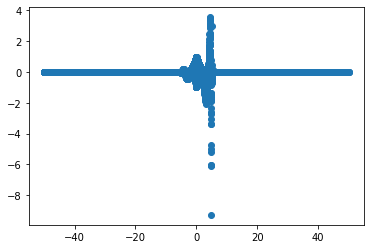

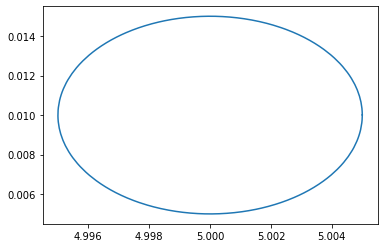

In [16]:

# network structure
in_dim  = 2
out_dim = 8
width = 2 ** 9   
depth = 5

# training setting
n_epch = int(3e4)
n_btch = int(2 ** 12)# 2**12=4096
c_tol  = 1e-8

# dataset prep
N_neg = int(2e4)   # evaluates R-
N_plus = int(2e4)   # evaluates R+
N_junc = int(2e4)   # evaluates R_junction

# optimization
w_init = "Glorot"
b_init = "zeros"
act = "selu"
lr0 = 5e-2
gam = 1e-2
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    decay_rate = gam, 
    staircase = False
    )
lr = lrd_exp   # 1e-3 / lrd_exp / lrd_cos
opt = "Adam"
f_scl = "minmax"
laaf = False

# system param
# rho = 1.
# nu  = .01

# weight
w_plus = 1.
w_neg = 1.
w_junc = 1.

# rarely change
f_mntr = 10
r_seed = 1234

def params():
    print("python    :", sys.version)
    print("tensorflow:", tf.__version__)
    print("rand seed :", r_seed)
    os.environ["PYTHONHASHSEED"] = str(r_seed)
    np.random.seed(r_seed)
    tf.random.set_seed(r_seed)

    return in_dim, out_dim, width, depth, \
        w_init, b_init, act, \
        lr, opt, \
        f_scl, laaf, \
        w_plus, w_neg, w_junc,\
        f_mntr, r_seed, \
        n_epch, n_btch, c_tol, \
        N_plus, N_neg, N_junc
config_gpu(gpu_flg = 1)
in_dim, out_dim, width, depth, \
        w_init, b_init, act, \
        lr, opt, \
        f_scl, laaf, \
        w_plus, w_neg, w_junc,\
        f_mntr, r_seed, \
        n_epch, n_btch, c_tol, \
        N_plus, N_neg, N_junc=params()


# Training dataset 

In [ ]:
N1=50000  # training data size in range 1 real range(-20,20), imaginary range(-6,6)
N2=30000  # training data size in range 2 real range(-50,50), imaginary range(-50,50)

###### load PQVR_V8.mat that include the integral path
AN=scio.loadmat('PQVR_V8.mat')
x_circle_plus=tf.convert_to_tensor(AN['x_circle_plus'],dtype=tf.float32)
y_circle_plus=tf.convert_to_tensor(AN['y_circle_plus'],dtype=tf.float32)
x_circle_neg=tf.convert_to_tensor(AN['x_circle_neg'],dtype=tf.float32)
y_circle_neg=tf.convert_to_tensor(AN['y_circle_neg'],dtype=tf.float32)

###### generate training data in the region 1: real range(-20,20), imaginary range(-6,6)
x_plus1=(np.random.random([N1,1])-0.5)*40
y_plus1=(np.random.random([N1,1])-0.5)*12
x_junc1=(np.random.random([N1,1])-0.5)*40
y_junc1=(np.random.random([N1,1])-0.5)*0.01 
x_neg1=(np.random.random([N1,1])-0.5)*40
y_neg1=(np.random.random([N1,1]))*(-20)-0.08

###### generate training data in the region 2: real range(-50,50), imaginary range(-50,50)
x_plus2=(np.random.random([N2,1])-0.5)*100
y_plus2=(np.random.random([N2,1])-0.5)*100
x_junc2=(np.random.random([N2,1])-0.5)*40
y_junc2=(np.random.random([N2,1])-0.5)*0.01
x_neg2=(np.random.random([N2,1])-0.5)*100
y_neg2=(np.random.random([N2,1]))*(-20)-0.08

x_plus=np.append(x_plus1,x_plus2,axis=0)
y_plus=np.append(y_plus1,y_plus2,axis=0)
x_junc=np.append(x_junc1,x_junc2,axis=0)
y_junc=np.append(y_junc1,y_junc2,axis=0)
x_neg=np.append(x_neg1,x_neg2,axis=0)
y_neg=np.append(y_neg1,y_neg2,axis=0)

def getp(w1,w2):
    x=tf.complex([w1],[w2])
    k=tf.complex([5.0],[0.01])
    gamma=tf.sqrt(tf.square(x)-tf.square(k))
    z=-gamma/2*0+1
    xr=tf.compat.v1.real(z)
    xi=tf.compat.v1.imag(z)
    return xr,xi  
def getq(w1,w2):
    x=tf.complex([w1],[w2])
    k=tf.complex([5.0],[0.01])
    gamma=tf.sqrt(tf.square(x)-tf.square(k))
    j0=tf.complex([0.0],[1.0])
    a=tf.complex([0.0],[0.0])
    h=tf.complex([2.0],[0.0])
    gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
    gamma_neg=tf.sqrt(k-x)
    gamma_plus=gammaj/gamma_neg

    z=gamma_neg/gamma_plus*tf.exp(-h*gamma)
    xr=tf.compat.v1.real(z)
    xi=tf.compat.v1.imag(z)
    return xr,xi      
def getr(w1,w2):
    x=tf.complex([w1],[w2])
    k=tf.complex([5.0],[0.01])
    gamma=tf.sqrt(tf.square(x)-tf.square(k))
    j0=tf.complex([0.0],[1.0])
    a=tf.complex([0.0],[0.0])
    h=tf.complex([2.0],[0.0])
    gammaj=j0*tf.sqrt(tf.square(x)-tf.square(k))
    gamma_neg=tf.sqrt(k-x)
    gamma_plus=gammaj/gamma_neg
#         gamma=gamma_plus*gamma_neg
    z=-gamma_plus/gamma_neg*tf.exp(-h*gamma)
    xr=tf.compat.v1.real(z)
    xi=tf.compat.v1.imag(z)
    return xr,xi     
def gets(w1,w2):
    x=tf.complex([w1],[w2])
    k=tf.complex([5.0],[0.01])
    gamma=tf.sqrt(tf.square(x)-tf.square(k))
    z=-gamma/2*0+1
    xr=tf.compat.v1.real(z)
    xi=tf.compat.v1.imag(z)
    return xr,xi 
x_plus=tf.convert_to_tensor(x_plus,dtype=tf.float32)
y_plus=tf.convert_to_tensor(y_plus,dtype=tf.float32)
prt_plus,pit_plus=getp(x_plus,y_plus)
qrt_plus,qit_plus=getq(x_plus,y_plus)
rrt_plus,rit_plus=getr(x_plus,y_plus)
srt_plus,sit_plus=gets(x_plus,y_plus)
prt_plus=prt_plus[0];pit_plus=pit_plus[0];qrt_plus=qrt_plus[0];qit_plus=qit_plus[0];
rrt_plus=rrt_plus[0];rit_plus=rit_plus[0];srt_plus=srt_plus[0];sit_plus=sit_plus[0];
x_junc=tf.convert_to_tensor(x_junc,dtype=tf.float32)
y_junc=tf.convert_to_tensor(y_junc,dtype=tf.float32)
prt_junc,pit_junc=getp(x_junc,y_junc)
qrt_junc,qit_junc=getq(x_junc,y_junc)
rrt_junc,rit_junc=getr(x_junc,y_junc)
srt_junc,sit_junc=gets(x_junc,y_junc)
prt_junc=prt_junc[0];pit_junc=pit_junc[0];qrt_junc=qrt_junc[0];qit_junc=qit_junc[0];
rrt_junc=rrt_junc[0];rit_junc=rit_junc[0];srt_junc=srt_junc[0];sit_junc=sit_junc[0];
x_neg=tf.convert_to_tensor(x_neg,dtype=tf.float32)
y_neg=tf.convert_to_tensor(y_neg,dtype=tf.float32)
prt_neg,pit_neg=getp(x_neg,y_neg)
qrt_neg,qit_neg=getq(x_neg,y_neg)
rrt_neg,rit_neg=getr(x_neg,y_neg)
srt_neg,sit_neg=gets(x_neg,y_neg)
prt_neg=prt_neg[0];pit_neg=pit_neg[0];qrt_neg=qrt_neg[0];qit_neg=qit_neg[0];
rrt_neg=rrt_neg[0];rit_neg=rit_neg[0];srt_neg=srt_neg[0];sit_neg=sit_neg[0];

x_circle_neg=tf.convert_to_tensor(x_circle_neg,dtype=tf.float32)
y_circle_neg=tf.convert_to_tensor(y_circle_neg,dtype=tf.float32)
x_circle_plus=tf.convert_to_tensor(x_circle_plus,dtype=tf.float32)
y_circle_plus=tf.convert_to_tensor(y_circle_plus,dtype=tf.float32)
print((qrt_plus))
plt.scatter(x_plus,rit_plus)
meanp,vp=tf.nn.moments(pit_junc,[0])
print(vp)
plt.figure()
plt.plot(x_circle_plus[0:2000],y_circle_plus[0:2000])

# Train the neural network

In [18]:
################## test
width=512
depth=6
lr0=1e-4
n_epch = int(3e4)
gam=0.01
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr0, 
    decay_steps = n_epch, 
    decay_rate = gam, 
    staircase = False
    )
# lrd_cos = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate = lr0, 
#     decay_steps = n_epch, 
#     alpha = gam
#     )

pinn = MINN(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
             Rm = in_dim, Rn = out_dim, Rl = width, depth=depth, activ = 'relu', BN = False, 
             w_init = "glorot_normal", b_init = "zero", 
             lr =lrd_exp, opt = "Adam",  w_k = 100, w_cr = 1, w_z = 0.1,w_dense = 0.1,
             f_mntr = 10, r_seed = 1234)
# w_k loss_plus
# w_cr loss_junc
pinn.load_weight('dnn1_mat_w5.h5')

# first train on mse to 5e-3
# second train on mae to 1e-4

n_btch = int(2 ** 14)# 2**13=8192
c_tol  = 5e-6
with tf.device("/device:GPU:0"):
    pinn.train(n_epch, n_btch, c_tol)
# pinn.save_weight('dnn1.h5')### lr=1e-5


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2023-11-10 09:31:12.373601
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : relu
         weight init  : glorot_normal
         learning rate: <tensorflow.python.keras.optimizer_v2.learning_rate_schedule.ExponentialDecay object at 0x7f2056b82e20>
         optimizer    : Adam
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    

KeyboardInterrupt: 

# Save weights

In [19]:
# pinn.save_weight('dnn1_mat_w5.h5')### train from:dnn28_mat_2factor，2**14,5e-3=lrd_exp,,range(0,400,2),0:0.1:40,40:1:240,w_k=100,N1=50000 
pinn.save_weight('dnn2_mat_w5.h5')### train from:dnn1_mat_w5，2**14,1e-4=lrd_exp,,range(0,600,2),0:0.1:40,40:1:240,w_k=100,N1=50000 

# View the factorization result


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2023-11-10 17:32:42.349911
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : relu
         weight init  : glorot_normal
         learning rate: 0.0001
         optimizer    : Adam
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (

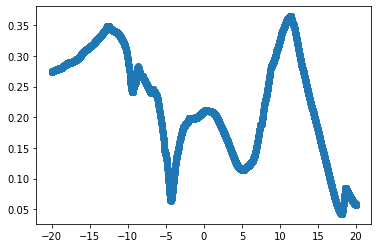

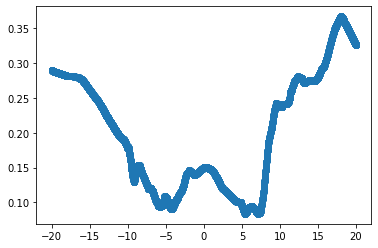

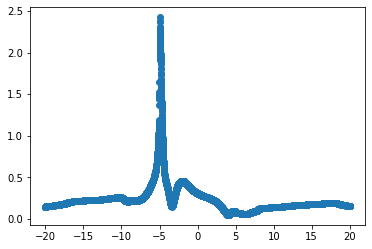

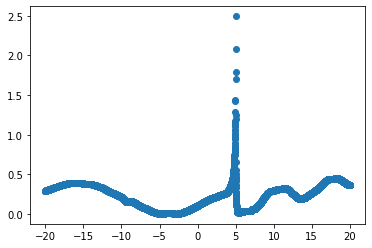

In [20]:
################## test
width=512
depth=6
M=10000
pinn = PINN_dnn(x_plus, y_plus, prt_plus,pit_plus,qrt_plus,qit_plus,rrt_plus,rit_plus,srt_plus,sit_plus,
                x_neg, y_neg, prt_neg,pit_neg,qrt_neg,qit_neg,rrt_neg,rit_neg,srt_neg,sit_neg,
                x_junc, y_junc, prt_junc,pit_junc,qrt_junc,qit_junc,rrt_junc,rit_junc,srt_junc,sit_junc,x_circle_plus,y_circle_plus,x_circle_neg,y_circle_neg,
             Rm = in_dim, Rn = out_dim, Rl = width, depth=depth, activ = 'relu', BN = False, 
             w_init = "glorot_normal", b_init = "zero", 
             lr = 1e-4, opt = "Adam",  w_k = 1., w_cr = 1., w_z = 1.,w_dense = 0.1,
             f_mntr = 10, r_seed = 1235)
pinn.load_weight('dnn2_mat_w5.h5')

pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8=pinn.predict(x_junc[0:M,:], y_junc[0:M,:])
# from mpl_toolkits.mplot3d import Axes3D
# ax=plt.axes(projection="3d")
# # ax.scatter3D(x_neg[0:M,:],y_neg[0:M,:],si)

# ax.scatter3D(x_neg[0:M,:],y_neg[0:M,:],si2)
plt.scatter(x_junc[0:M,:],tf.sqrt(tf.square(pr)+tf.square(pi)))
# plt.title('gv1')
plt.figure()
plt.scatter(x_junc[0:M,:],tf.sqrt(tf.square(sr)+tf.square(si)))
plt.figure()
plt.scatter(x_junc[0:M,:],tf.sqrt(tf.square(qr2)+tf.square(qi2)))
# plt.scatter(x_plus,rrt_plus)
plt.figure()
plt.scatter(x_junc[0:M,:],tf.sqrt(tf.square(rr2)+tf.square(ri2)))
# plt.scatter(x_plus,rit_plus)
print(pr)

## SAVE TO MAT

pr2.shape:(10000, 1)
pr.shape:(10000, 1)
prt.shape:(10000, 1)
pr2.shape:(1, 1)
pr.shape:(1, 1)
prt.shape:(1, 1)
[[-0.005]]
pr2.shape:(101, 1)
pr.shape:(101, 1)
prt.shape:(101, 1)
pr2.shape:(101, 1)
pr.shape:(101, 1)
prt.shape:(101, 1)


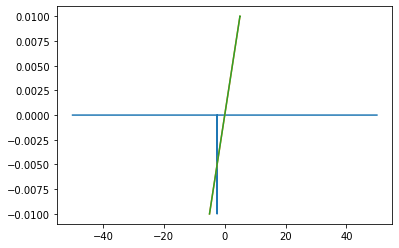

In [21]:
###### G_{+}^{-1}(\alpha) on the integral path C
AB=scio.loadmat('xy_pre.mat')
x_test=AB['x_pre'];y_test=AB['y_pre']
# pinn.load_weight('dnn3_first.h5')
plt.plot(x_test,y_test)
pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8=pinn.predict(x_test, y_test)

scio.savemat('G_mat w_5.mat',{'pr':pr.numpy(),'pi':pi.numpy(),'qr':qr.numpy(),'qi':qi.numpy(),'rr':rr.numpy(),'ri':ri.numpy()
                     ,'sr':sr.numpy(),'si':si.numpy(),
                     'pr2':pr2.numpy(),'pi2':pi2.numpy(),'qr2':qr2.numpy(),'qi2':qi2.numpy(),'rr2':rr2.numpy(),'ri2':ri2.numpy()
                     ,'sr2':sr2.numpy(),'si2':si2.numpy()})
AB=scio.loadmat('k0_pre.mat')
x_test=AB['x_k0'];y_test=AB['y_k0']
# pinn.load_weight('dnn1.h5')

###### G_{+}^{-1}(-k0)
pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8=pinn.predict(x_test, y_test)

scio.savemat('GK_mat w_5.mat',{'prk':pr.numpy(),'pik':pi.numpy(),'qrk':qr.numpy(),'qik':qi.numpy(),'rrk':rr.numpy(),'rik':ri.numpy()
                     ,'srk':sr.numpy(),'sik':si.numpy()})
print(y_test)

###### G_{+}^{-1}(\alpha) for zone 1 far-field result
AB=scio.loadmat('xy_pre_v1 w_5.mat')
x_test=AB['x_pre'];y_test=AB['y_pre']
# pinn.load_weight('dnn3_first.h5')
plt.plot(x_test,y_test)
pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8=pinn.predict(x_test, y_test)

scio.savemat('Gkcos_mat1 w_5.mat',{'pr':pr.numpy(),'pi':pi.numpy(),'qr':qr.numpy(),'qi':qi.numpy(),'rr':rr.numpy(),'ri':ri.numpy()
                     ,'sr':sr.numpy(),'si':si.numpy(),
                     'pr2':pr2.numpy(),'pi2':pi2.numpy(),'qr2':qr2.numpy(),'qi2':qi2.numpy(),'rr2':rr2.numpy(),'ri2':ri2.numpy()
                     ,'sr2':sr2.numpy(),'si2':si2.numpy()})

###### G_{+}^{-1}(\alpha) for zone 3 far-field result
AB=scio.loadmat('xy_pre_v3 w_5.mat')
x_test=AB['x_pre'];y_test=AB['y_pre']
# pinn.load_weight('dnn3_first.h5')
# plt.plot(x_test,y_test)
pr,pi,qr,qi,rr,ri,sr,si,\
               pr2,pi2,qr2,qi2,rr2,ri2,sr2,si2,\
               gv1,gv2,gv3,gv4,gv5,gv6,gv7,gv8,\
               gh1,gh2,gh3,gh4,gh5,gh6,gh7,gh8=pinn.predict(x_test, y_test)

scio.savemat('Gkcos_mat3 w_5.mat',{'pr':pr.numpy(),'pi':pi.numpy(),'qr':qr.numpy(),'qi':qi.numpy(),'rr':rr.numpy(),'ri':ri.numpy()
                     ,'sr':sr.numpy(),'si':si.numpy(),
                     'pr2':pr2.numpy(),'pi2':pi2.numpy(),'qr2':qr2.numpy(),'qi2':qi2.numpy(),'rr2':rr2.numpy(),'ri2':ri2.numpy()
                     ,'sr2':sr2.numpy(),'si2':si2.numpy()})